In [1]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
import os
os.sys.path.extend(['../evaluation'])
from evaluate import model_preprocessed_filepath
import glob
from matplotlib import pyplot as plt
import math
%matplotlib inline

chencherry = SmoothingFunction().method2

In [8]:
def get_scores(filepath, set_='test', subset='old-cat'):
    
    references_files = [f'../evaluation/references/{set_}/{subset}_reference{i}.lex' for i in range(3)]
    hypothesis_file = filepath

    scores = []
    hypothesis = []
    references = []

    with open(references_files[0], 'r', encoding='utf-8') as ref0,\
         open(references_files[1], 'r', encoding='utf-8') as ref1,\
         open(references_files[2], 'r', encoding='utf-8') as ref2,\
         open(hypothesis_file, 'r', encoding='utf-8') as hyp:


        for h, r0, r1, r2 in zip(hyp, ref0, ref1, ref2):

            references.append((r0[:-1], r1[:-1], r2[:-1]))
            hypothesis.append(h[:-1])

    for hyp, refs in zip(hypothesis, references):

        score = sentence_bleu([r.split() for r in refs], 
                              hyp.split(), 
                              smoothing_function=chencherry)

        scores.append(score)
        
    return scores, hypothesis, references
    

def plot_hist_bleu(filepath, ax, subset='all-cat'):

    scores, _, _ = get_scores(filepath, subset)
    
    s = pd.Series(scores)
    
    s.hist(ax=ax, bins=40)

In [3]:
def plot_all_models_hist_bleu(subset):
    
    models = [os.path.basename(s) for s in glob.glob('../data/models/*')]

    n_models = len(models)
    n_columns = 3
    n_rows = math.ceil(n_models / 3)

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 5*n_rows), sharey=True, sharex=True)

    for model, ax in zip(models, axes.ravel()):

        try:
            filepath = model_preprocessed_filepath(model, subset)
        except FileNotFoundError as e:
            pass

        plot_hist_bleu(filepath, ax, subset)
        ax.set_title(model)

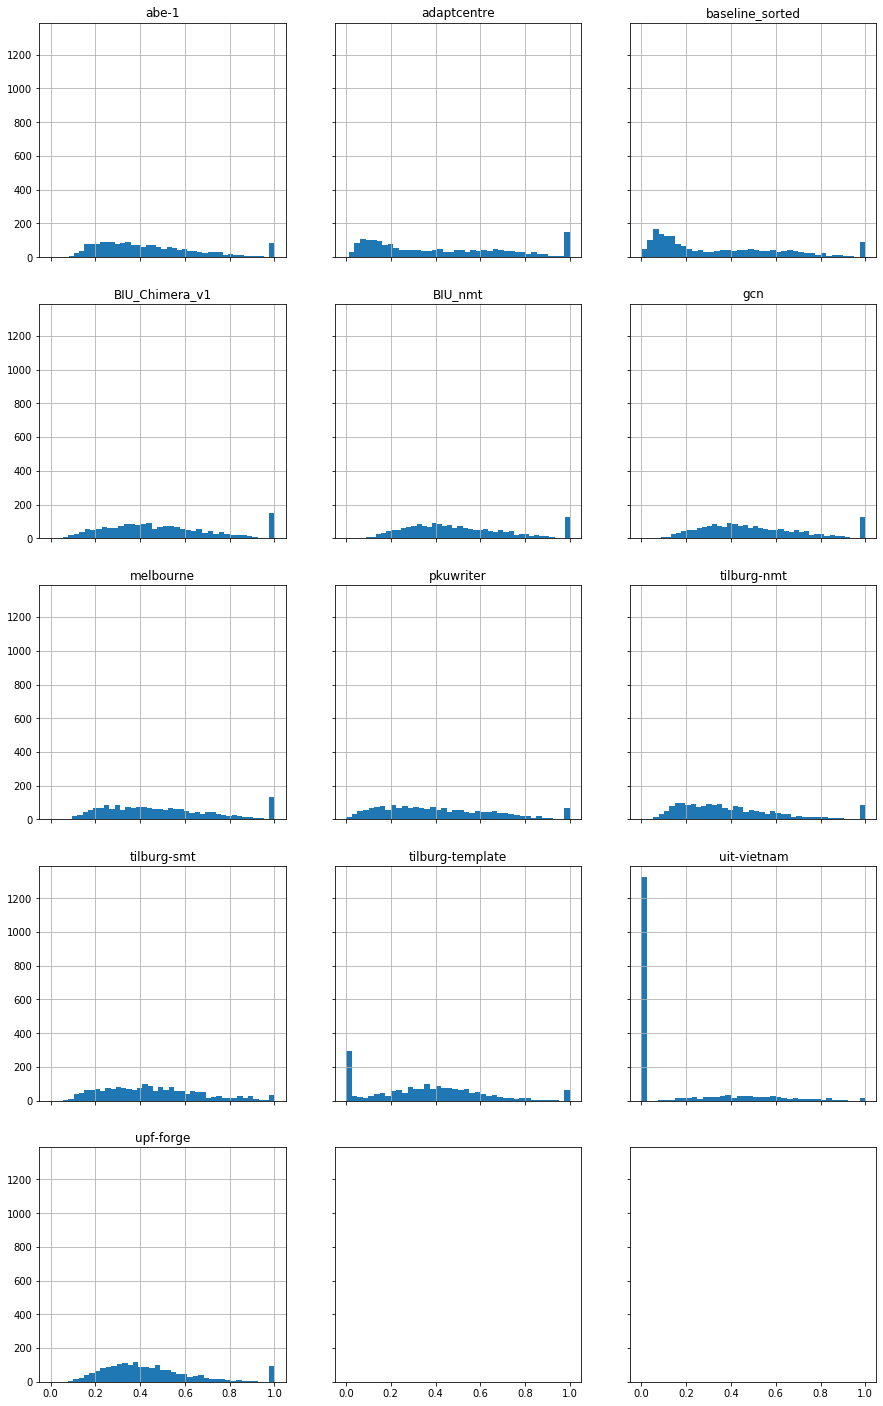

In [8]:
plot_all_models_hist_bleu('all-cat')

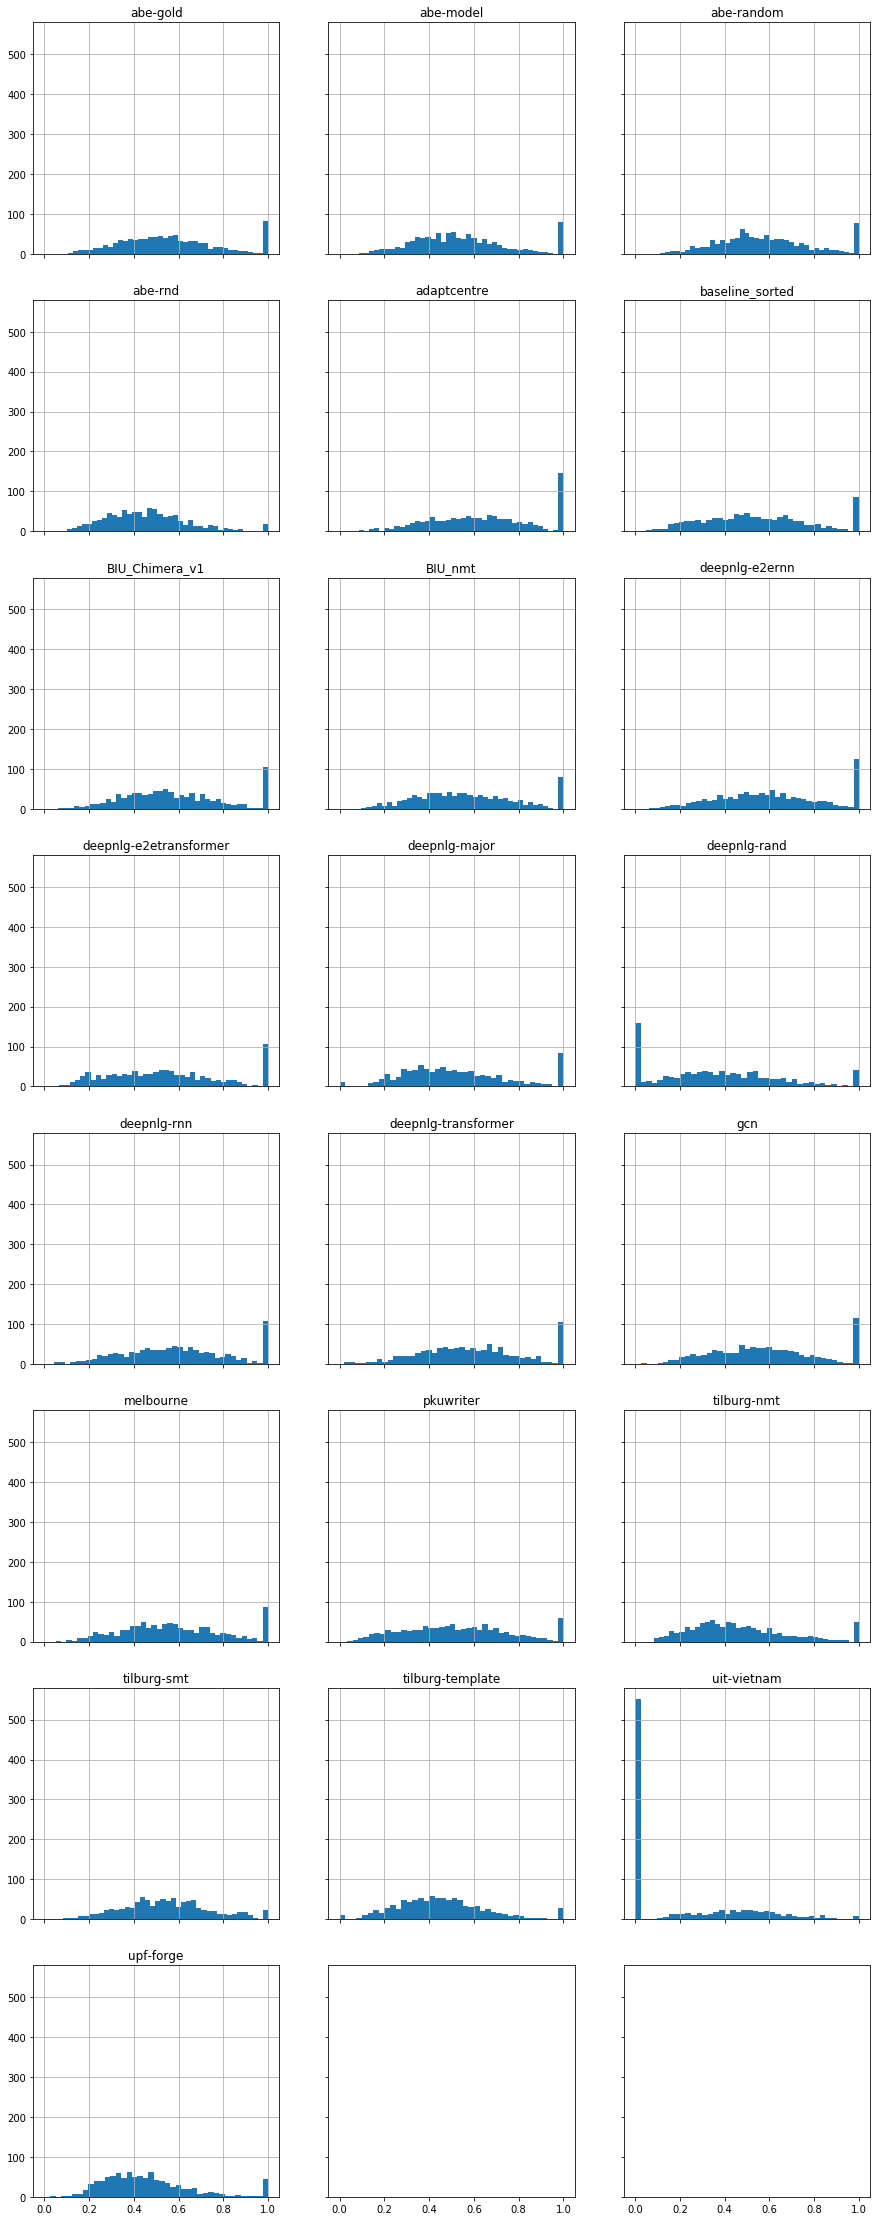

In [4]:
plot_all_models_hist_bleu('old-cat')

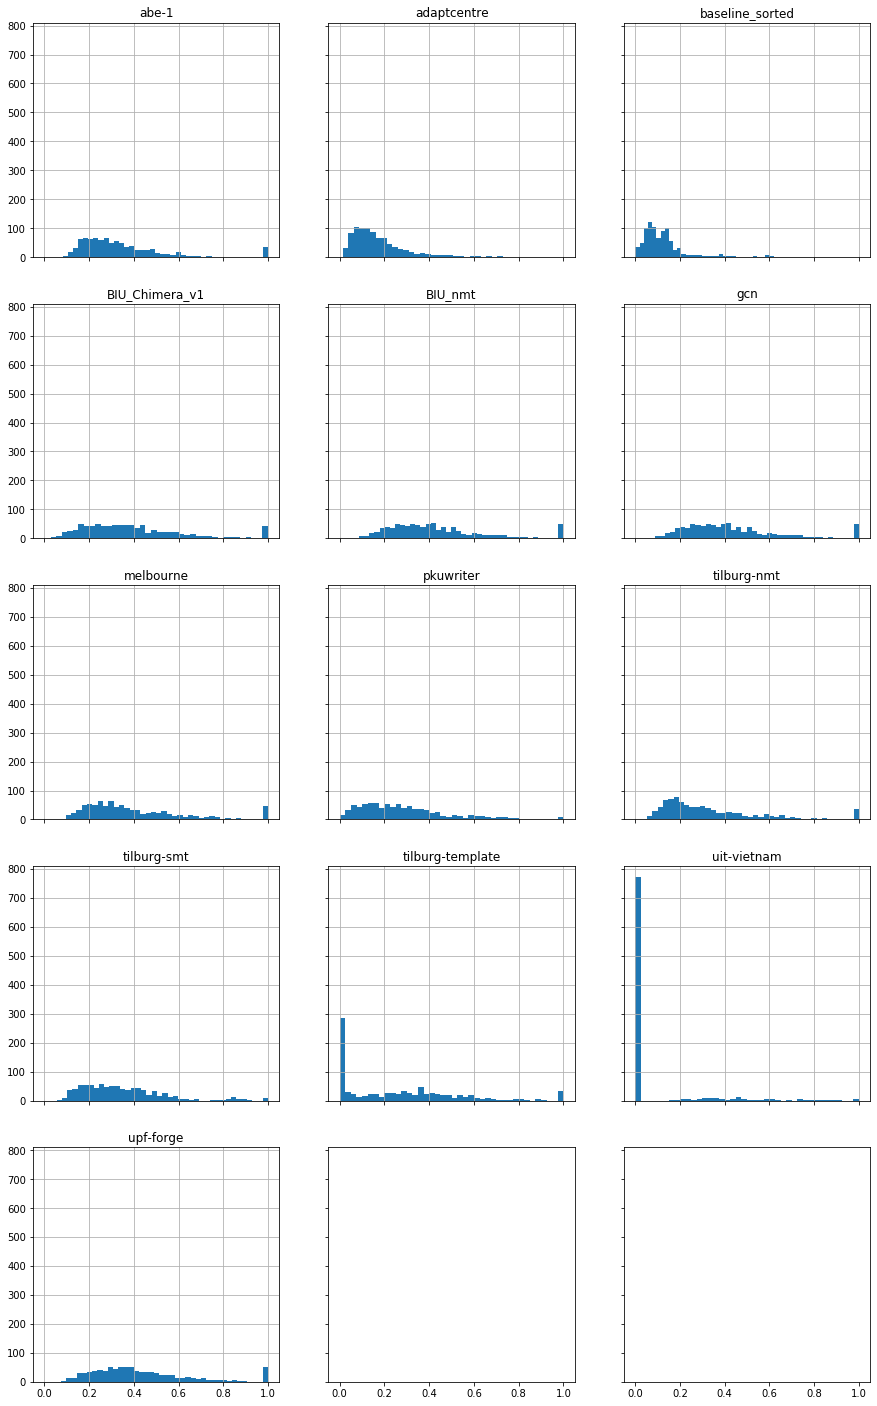

In [10]:
plot_all_models_hist_bleu('new-cat')

# Menores scores

In [10]:
models = ['abe', 'adaptcentre', 'gcn']

sc = {}
hyps = {}

for model in models:
    
    scores, hypothesis, _ = get_scores(model_preprocessed_filepath(model, 'test', 'old-cat'))
    
    sc[f'{model}_bleu'] = scores
    hyps[f'{model}_hyp'] = hypothesis
    
data = {}
data.update(sc)
data.update(hyps)

In [11]:
import pandas as pd

pd.set_option('display.max_colwidth', 1000)

df = pd.DataFrame(data)

scores_cols = list(sc.keys())

df['mean_bleu'] = df[scores_cols].mean(axis=1)
df['min_bleu'] = df[scores_cols].min(axis=1)
df['max_bleu'] = df[scores_cols].max(axis=1)
df['range_bleu'] = df['max_bleu'] - df['min_bleu']
df['abe_to_max'] = df['max_bleu'] - df['abe_bleu']

In [13]:
df[df.abe_to_max > 0.5].sample(3)

,abe_bleu,adaptcentre_bleu,gcn_bleu,abe_hyp,adaptcentre_hyp,gcn_hyp,mean_bleu,min_bleu,max_bleu,range_bleu,abe_to_max
26,0.472871,1.000000,0.469052,danes are people of denmark .,the people of denmark are called danes .,denmark ' s demonym is danes .,0.647308,0.469052,1.000000,0.530948,0.527129
110,0.491327,1.000000,1.000000,az alkmaar played in the eredivisie for the season 2014 - 2015 .,az alkmaar played in the eredivisie in 2014 - 15 .,az alkmaar played in the eredivisie in 2014 - 15 .,0.830442,0.491327,1.000000,0.508673,0.508673
551,0.260802,0.465076,0.784047,sponge cake baked alaska is from new york and france .,"sponge cake is an ingredient in baked alaska , which comes from both france and the new york region .",sponge cake is an ingredient of baked alaska which comes from france and new york .,0.503308,0.260802,0.784047,0.523246,0.523246


# Avaliando com textos gerados pelo template

In [3]:
import pickle

with open('../data/models/abe-2/milhoes_de_textos', 'rb') as f:
    references = pickle.load(f)

In [4]:
import re

c = re.compile(r'\W')

In [12]:
def get_scores(filepath):
    
    hypothesis_file = filepath

    scores = []
    hypothesis = []

    with open(hypothesis_file, 'r', encoding='utf-8') as hyp:

        for h in hyp:
            hypothesis.append(h[:-1])

    for hyp, refs in zip(hypothesis, references):

        score = sentence_bleu([c.split(r) for r in refs], 
                              c.split(hyp), 
                              smoothing_function=chencherry)

        scores.append(score)
        
    return scores
    

def plot_hist_bleu(filepath, ax):

    scores = get_scores(filepath)
    
    s = pd.Series(scores)
    
    s.hist(ax=ax, bins=40)
    
def plot_all_models_hist_bleu(subset):
    
    models = [os.path.basename(s) for s in glob.glob('../data/models/*')]

    n_models = len(models)
    n_columns = 3
    n_rows = math.ceil(n_models / 3)

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 5*n_rows), sharey=True, sharex=True)

    for model, ax in zip(models, axes.ravel()):

        filepath = model_preprocessed_filepath(model, subset)

        plot_hist_bleu(filepath, ax)
        ax.set_title(model)

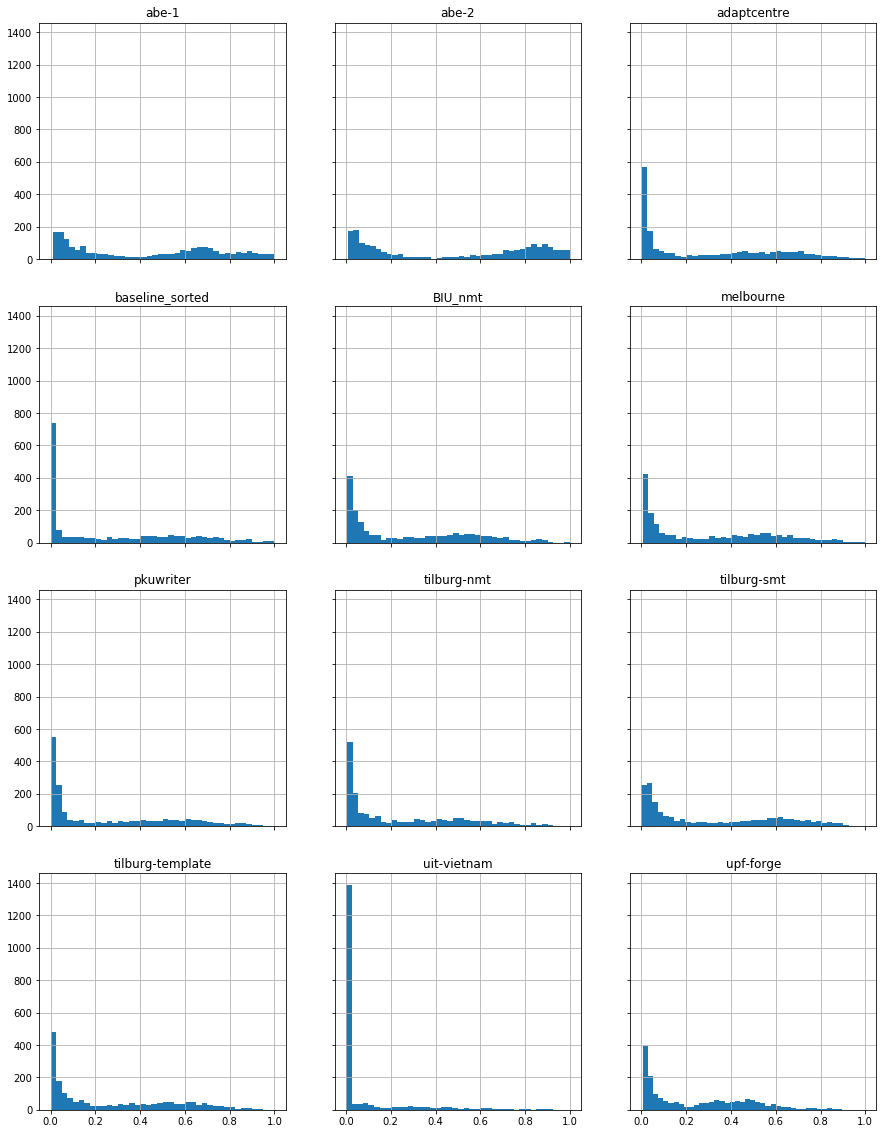

In [16]:
plot_all_models_hist_bleu('all-cat')